3 Tree based classification
-------------------

**Decision Tree** is the most widely used **additive** model for **supervised learning** that combines simple classification nodes for larger scale tasks of both **classification** and **regression**. In most cases, the basic element in the **decision tree** is a binary node that split the data further into two parts. In a tree, many of the nodes would split the data incrementally along the tree, and bring the final classes at a node (usually referred as the leaf) where the data would not be split any more. There are also cases that the data can be split into more than two classes as opposed to binary classes, such as the [**CHAID**](https://en.wikipedia.org/wiki/Chi-square_automatic_interaction_detection). In the case of **regression**, we can continue to apply simple analysis to capture the pattern within each classified subset of the data. Such as taking the average of the subset as a simple regressed value. We will be dealing with **regression** problem by using **decision tree** later. 

The logic of **additivity** can also be applied to **decision trees** to form an **ensemble model** call the **random forest** for **ensemble learning**. In **ensemble learning**, each tree is applied to the data and trained in same manner. The results of all the trees would then be averaged to produce the final result.

In this session, we will be focusing on **decision tree** and its application to the real GIS and Remote Sensing data that we have used in the previous sessions.

### 3.0 Decision tree based classification of real world GIS and Remote Sensing datasets.

Again, we will use the same dataset of the satellite images along with the labelled LULC types of the Netherlands. The labelled LULC types in the AOIs will be split into **training** and **test** datasets. The trained model will be applied to the larger area covering almost the entire Netherlands.

In [12]:
%matplotlib inline  # In order to plot figures inline in Jupyter Notebook, we need to run this. But please ignore this in Colab.

UsageError: unrecognized arguments: # In order to plot figures inline in Jupyter Notebook, we need to run this. But please ignore this in Colab.


In [ ]:
# Before reading the data we need to first clone the data on Github to our Colab workspace
!git clone https://github.com/jonwangio/uu_ml

In [1]:
# Same real world dataset as you have already encountered in the previous sessions.
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
% pip install geopandas
import geopandas as gpd
% pip install rasterio
import rasterio
from rasterio.plot import show
from sklearn.svm import SVC

# The data contains sample LULC areas around dutch provinces North Holland and Utrecht.
aoi = gpd.read_file('uu_ml/data/aoi_NL_5_classes.shp')

print (aoi.head())

     id   land_cover  class                                           geometry
0  None  Clear water     11  POLYGON ((638038.588 5776433.484, 637916.087 5...
1  None  Clear water     11  POLYGON ((638293.014 5776226.174, 638669.940 5...
2  None  Clear water     11  POLYGON ((642646.516 5779109.663, 643438.062 5...
3  None  Clear water     11  POLYGON ((658307.816 5795505.970, 659438.596 5...
4  None  Clear water     11  POLYGON ((617048.489 5789668.319, 617764.649 5...


C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


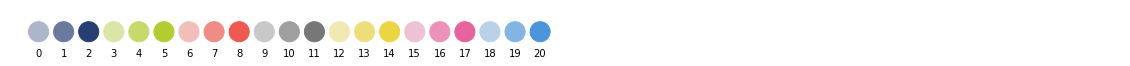

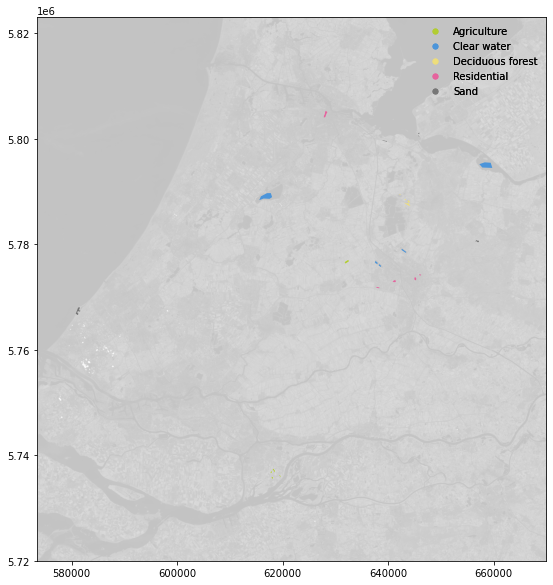

In [2]:
# Below is a visualization of the sample LULC areas superimposed on a satellite image of part of the Netherlands
file_location = 'uu_ml/data/b5_2015.TIF'
b5_2020 = rasterio.open(file_location, nodata=0)

# We also prepare the color codes for visualization
colors = [(257, 71, 27), (98, 93, 78), (14, 79, 58), (26, 0, 50), (75, 90, 85), (347, 72, 60), (246, 79, 60)]
cols = []
for col in colors:
    pal = sns.light_palette(col, input="husl", n_colors=4)
    for rgb in pal[1:]:
        cols.append(rgb)

# A preview of color codes. Please delete the triple quotation marks to run the code.

fig, ax = plt.subplots(figsize=(20, 5))
for i, c in enumerate(cols):
    ax.add_artist(plt.Circle((i, 0), 0.4, color=c))
    plt.text(i, -1, i, horizontalalignment='center')
    ax.set_axis_off()
    ax.set_aspect(1)
    ax.autoscale()
    plt.xlim(-1.25,43.25)
    plt.ylim(-1,1)


# Assign color codes to LULC types 
symbology = {'Agriculture': cols[5],
             'Clear water': cols[20],
             'Deciduous forest': cols[13],
             'Residential': cols[17],
             'Sand': cols[11]}

# Visualize
fig,ax = plt.subplots(1,1, figsize=(10,10))
show(b5_2020, ax=ax, cmap='gray', alpha=0.25)
aoi.plot(ax=ax, column='land_cover', legend=True, color=aoi['land_cover'].map(symbology))

from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=5, color=color) for color in symbology.values()]
leg_points = ax.legend(custom_points, symbology.keys(), loc='upper right', frameon=False)
ax.add_artist(leg_points)

As you may recall, we will prepare the **training** and **test** datasets from the sample LULC types in AOIs. We will use the two bands of satellite images as the inputs and the manually delineated LULC types in the AOIs as the output labels. Did you still remember how we stacked the data together and extract the input band pixels along with labels within the AOIs?

In [3]:
# Import necessary modules and functionalities

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread
from sklearn.svm import SVC

# As before, we start with loading and stacking the image bands.
# Again, we start with 2 bands that appeared to be useful for the small dataset.
file_list = ['uu_ml/data/b5_2015.TIF', 'uu_ml/data/b6_2015.TIF']  # List to store file names

# You can print to see how the file_list looks like
print(file_list)

# Read the files and stack them together by calling their names
# Use the 'for' loop to iterate over the names to read files
stack = np.array([])  # Empty array to store the stacked images
for file in file_list:
    img = imread(file)  # Read each image file
    print(img.shape)  # Each time, also check the size of the image
    
    # In order to do clustering, image should be reshaped into a single column
    img_col = img.reshape(-1, 1)
    
    # Each time put the reshaped image into the stack
    stack = np.hstack((stack,img_col)) if stack.size else img_col
    # Also to check the size of the stack
    print(stack.shape)

['data/b5_2015.TIF', 'data/b6_2015.TIF']
(3434, 3221)
(11060914, 1)
(3434, 3221)
(11060914, 2)


In [5]:
# We also need to rasterize our manually delineated LULC types in the AOIs as we did in previous sessions
# Use the rasterio again to rasterize the *.shp file

from rasterio import features
import pandas as pd

# Labels from the AOIs
aoi = gpd.read_file('uu_ml/data/aoi_NL_5_classes.shp')
aoi['aoi_cat'] = pd.Categorical(aoi['class'])

# Rasterize
rst = rasterio.open('uu_ml/data/b5_2015.TIF')  # Base image to rasterize the *.shp
meta = rst.meta.copy()  # Copy metadata from the base image
meta.update(compress='lzw')

# Burn the AOIs *.shp file into raster and save it
out_rst = 'uu_ml/data/aoi_rasterized.tif'
with rasterio.open(out_rst, 'w+', **meta) as out:
    out_arr = out.read(1)

    # Create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(aoi.geometry, aoi.aoi_cat))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

In [6]:
# we will further stack the rasterized labels from the AOIs with the input bands, and only focus on the pixels within the AOIs.
# The training and test datasets will be prepared from the pixels and labels within the AOIs

# Load the rasterized LULC types in the AOI and concatenate it together with the images

aoi_rst = rasterio.open('uu_ml/data/aoi_rasterized.tif').read(1)

# Stack the label with the input bands
data = np.c_[stack, aoi_rst.reshape(-1,)]

# Of course, we are only interested in pixels with LULC type labelled
data = data[np.where(data[:,data.shape[1]-1]!=0)]

# Recall our function for preparing training and test datasets.
# This time we re-write it a little bit to let the users of the function to split the data into training and test sets.

def trainTestSplit(x, y, training_proportion):
    data = np.c_[x, y]
    np.random.shuffle(data)  # Shuffle the data so that LULC types can spread over training and test sets
    x_train = data[:int(training_proportion*len(data)), :2]  # 70% of data for training
    x_test = data[int(training_proportion*len(data)):, :2]  # 30% for testing
    y_train = data[:int(training_proportion*len(data)), 2:].reshape(-1,)  # 70% of data for training
    y_test = data[int(training_proportion*len(data)):, 2:].reshape(-1,)  # 30% for testing
    return x_train, y_train, x_test, y_test

# This time, use a very small proportion of the data for training, say, 30%.
X_train, Y_train, X_test, Y_test = trainTestSplit(data[:,:-1], data[:,-1], 0.3)

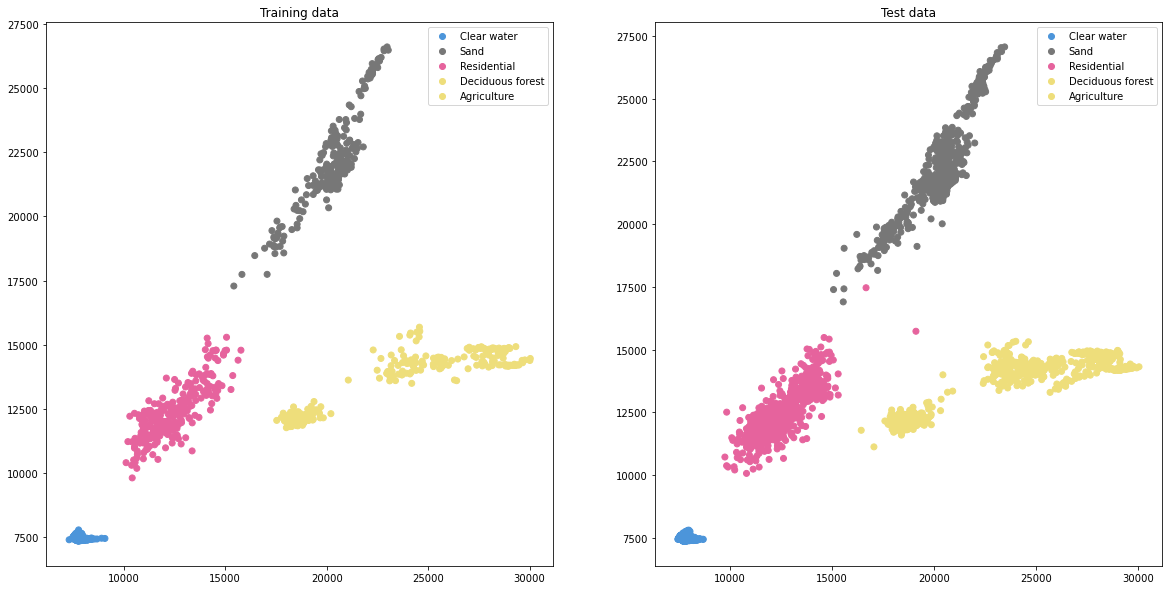

In [15]:
# Visualize the training and test datasets

from matplotlib.colors import ListedColormap

# Assign color codes to LULC types 
symbology2 = {11: cols[20],
              21: cols[11],
              31: cols[17],
              52: cols[5],
              61: cols[13]}

cm = ListedColormap(symbology2.values())
imin = min(symbology2)  # Colormap range
imax = max(symbology2)

# Visualize
classes = ['Clear water', 'Sand', 'Residential', 'Deciduous forest', 'Agriculture']

fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

scatter1 = ax1.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cm, vmin=imin, vmax=imax, label='LULC types')
ax1.set_title('Training data')
ax1.legend(handles=scatter1.legend_elements()[0], labels=classes)

ax2.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm, vmin=imin, vmax=imax, label='LULC types')
ax2.set_title('Test data')
ax2.legend(handles=scatter1.legend_elements()[0], labels=classes)

Now we have both the **training** and **test** datasets, where the inputs are pixel values from the two bands (2-dimensional data points), and the outputs are categorical LULC types (encoded as numerical numbers).

Given the fact that, as you already saw in previous sessions, the dataset we have is relatively simple to classify in the 2-dimensional feature space formed by the two bands, we will first try to inspect the **decision tree** with individual band, and see the model performance with only one band.

Try to interpret the visualization in terms of values for splits, number of samples in each split, how the split compared to the patterns in the scatterplots in the 2-dimensional feature space above? And where are the problems?

[Text(251.10000000000002, 428.08500000000004, 'X[0] <= 9586.5\ngini = 0.559\nsamples = 2256\nvalue = [1436, 254, 273, 160, 133]'),
 Text(167.4, 305.775, 'gini = 0.0\nsamples = 1436\nvalue = [1436, 0, 0, 0, 0]'),
 Text(334.8, 305.775, 'X[0] <= 15796.5\ngini = 0.729\nsamples = 820\nvalue = [0, 254, 273, 160, 133]'),
 Text(167.4, 183.46500000000003, 'X[0] <= 15394.5\ngini = 0.007\nsamples = 274\nvalue = [0, 1, 273, 0, 0]'),
 Text(83.7, 61.15499999999997, 'gini = 0.0\nsamples = 271\nvalue = [0, 0, 271, 0, 0]'),
 Text(251.10000000000002, 61.15499999999997, 'gini = 0.444\nsamples = 3\nvalue = [0, 1, 2, 0, 0]'),
 Text(502.20000000000005, 183.46500000000003, 'X[0] <= 22894.5\ngini = 0.64\nsamples = 546\nvalue = [0, 253, 0, 160, 133]'),
 Text(418.5, 61.15499999999997, 'gini = 0.464\nsamples = 388\nvalue = [0, 251, 0, 4, 133]'),
 Text(585.9, 61.15499999999997, 'gini = 0.025\nsamples = 158\nvalue = [0, 2, 0, 156, 0]')]

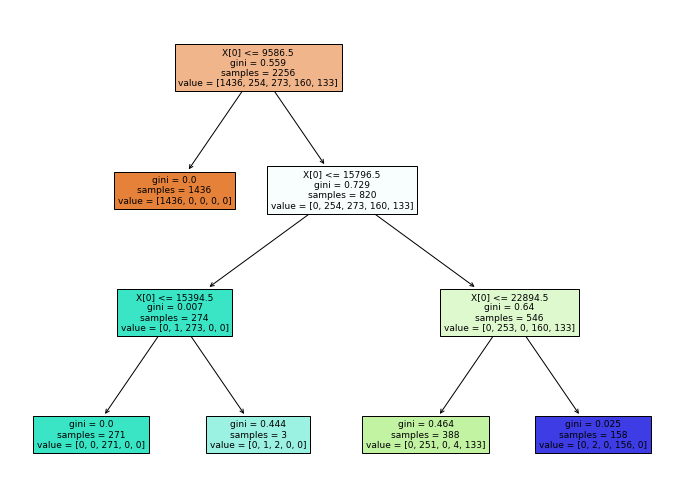

In [27]:
# Import sklearn along with all necessary modules

import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score,mean_squared_error

# Initiate a tree model
tree_depth = 3
model_tree = DecisionTreeClassifier(max_depth=tree_depth)

# Fit the model to your data.
# Please note that the output of this fitting is a model with several parameters that are configurable, so far you only configured "max_depth" while training/fitting.
model_tree.fit(X_train[:,0].reshape(-1,1), Y_train)

# Visualize split
fig = plt.figure(figsize=(tree_depth*4,tree_depth*3))
tree.plot_tree(model_tree, filled=True)

Further inspect the predictive performance by using the **confusion matrix** along with more detailed accuracy metrics. Now, do the accuracy metrics capture you visual comparison between the **decision tree** and the scatterplots in the feature space above. Which classes suffer the most from misclassification? And why?

In [28]:
Y_pred = pd.Series(list(model_tree.predict(X_test[:,0].reshape(-1,1))), name='DT prediction')  # Store the predicted value in Y_pred
Y_actu = pd.Series(list(Y_test), name='Manual delineation')

# Map the LULC codes to the actual name of LULC types

# First we need a mapping from the LULC codes to the actual LULC type name.
code_lulc = { 52: 'Agriculture',
              11: 'Clear water',
              61: 'Deciduous forest',
              31: 'Residential',
              21: 'Sand'}

# Now replace the non-intuitive numbers with actual LULC type names and store them into new variables
Y_actu2 = Y_actu.replace(code_lulc)
Y_pred2 = Y_pred.replace(code_lulc)

# Show the LULC coded confusion matrix
df_confusion2 = pd.crosstab(Y_actu2, Y_pred2)
df_confusion2

DT prediction,Agriculture,Clear water,Residential,Sand
Manual delineation,,,,
Agriculture,377,0,0,14
Clear water,0,3271,0,0
Deciduous forest,0,0,0,337
Residential,0,0,624,2
Sand,9,0,5,627


In [29]:
# Print out more detailed accuracy assessment report

from sklearn.metrics import classification_report

print(classification_report(Y_actu2, Y_pred2))

                  precision    recall  f1-score   support

     Agriculture       0.98      0.96      0.97       391
     Clear water       1.00      1.00      1.00      3271
Deciduous forest       0.00      0.00      0.00       337
     Residential       0.99      1.00      0.99       626
            Sand       0.64      0.98      0.77       641

        accuracy                           0.93      5266
       macro avg       0.72      0.79      0.75      5266
    weighted avg       0.89      0.93      0.91      5266



C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

### 3.1 Further inspection: features and model configurations

Now you may want to try both bands in the sample datasets, and experiment with model configurations. Please pay attention to how the splits are shown with two features (bands). And please do modify the model configuration such as the ***tree depth***.

[Text(251.10000000000002, 428.08500000000004, 'X[0] <= 9586.5\ngini = 0.559\nsamples = 2256\nvalue = [1436, 254, 273, 160, 133]'),
 Text(167.4, 305.775, 'gini = 0.0\nsamples = 1436\nvalue = [1436, 0, 0, 0, 0]'),
 Text(334.8, 305.775, 'X[0] <= 15796.5\ngini = 0.729\nsamples = 820\nvalue = [0, 254, 273, 160, 133]'),
 Text(167.4, 183.46500000000003, 'X[1] <= 16292.0\ngini = 0.007\nsamples = 274\nvalue = [0, 1, 273, 0, 0]'),
 Text(83.7, 61.15499999999997, 'gini = 0.0\nsamples = 273\nvalue = [0, 0, 273, 0, 0]'),
 Text(251.10000000000002, 61.15499999999997, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0, 0]'),
 Text(502.20000000000005, 183.46500000000003, 'X[1] <= 16714.5\ngini = 0.64\nsamples = 546\nvalue = [0, 253, 0, 160, 133]'),
 Text(418.5, 61.15499999999997, 'gini = 0.496\nsamples = 293\nvalue = [0, 0, 0, 160, 133]'),
 Text(585.9, 61.15499999999997, 'gini = 0.0\nsamples = 253\nvalue = [0, 253, 0, 0, 0]')]

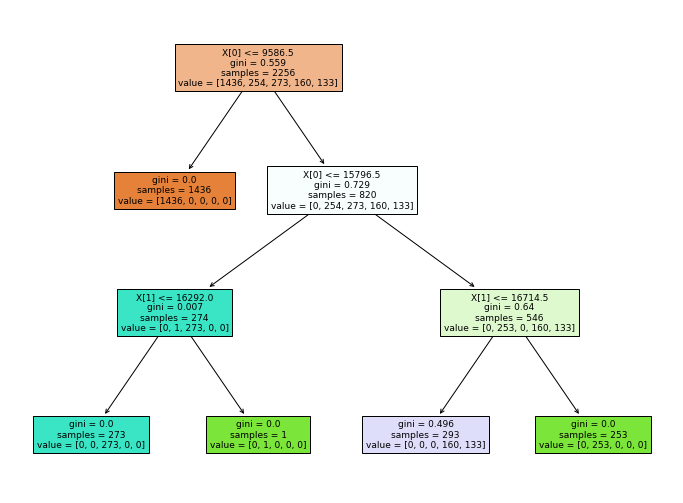

In [38]:
from sklearn import tree

# Initiate a tree model
tree_depth = 3
model_tree = DecisionTreeClassifier(max_depth=tree_depth)

# Fit the model to your data.
# Please note that the output of this fitting is a model with several parameters that are configurable, so far you only configured "max_depth" while training/fitting.
model_tree.fit(X_train, Y_train)

# Visualize split
fig = plt.figure(figsize=(tree_depth*4,tree_depth*3))
tree.plot_tree(model_tree, filled=True)

In [39]:
# Again, make predictions and compare with the known labels.

Y_pred = pd.Series(list(model_tree.predict(X_test)), name='DT prediction')  # Store the predicted value in Y_pred
Y_actu = pd.Series(list(Y_test), name='Manual delineation')

# Now replace the non-intuitive numbers with actual LULC type names and store them into new variables
Y_actu2 = Y_actu.replace(code_lulc)
Y_pred2 = Y_pred.replace(code_lulc)

# Show the LULC coded confusion matrix
df_confusion2 = pd.crosstab(Y_actu2, Y_pred2)
df_confusion2

DT prediction,Agriculture,Clear water,Residential,Sand
Manual delineation,,,,
Agriculture,391,0,0,0
Clear water,0,3271,0,0
Deciduous forest,337,0,0,0
Residential,1,0,624,1
Sand,0,0,0,641


In [40]:
# Print out more detailed accuracy assessment report

from sklearn.metrics import classification_report

print(classification_report(Y_actu2, Y_pred2))

                  precision    recall  f1-score   support

     Agriculture       0.54      1.00      0.70       391
     Clear water       1.00      1.00      1.00      3271
Deciduous forest       0.00      0.00      0.00       337
     Residential       1.00      1.00      1.00       626
            Sand       1.00      1.00      1.00       641

        accuracy                           0.94      5266
       macro avg       0.71      0.80      0.74      5266
    weighted avg       0.90      0.94      0.91      5266



C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

If you do have a lot of **features** of the input *x* in the form of *(x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub>,..., x<sub>n</sub>)*, you may soon get lost about how the data is split in the feature space and what the values mean in the tree nodes. However, there are many options to visualize the data splits along the tree. 

At the same time, you have already seen that some data value are better split along specific feature/dimension. It means that certain data point of a dimension or feature can be used best for capture data variance. Hence it is possible to rank feature importance in classification. 

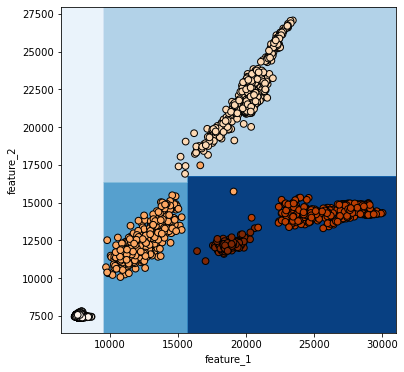

In [44]:
# The tree can also be visualized in a different way to see how data has been splitted.
# Let's plot how the features split the data

# Plot parameters
plot_colors = "ryb"
plot_step = 100

# Plot the decision boundary
plt.figure(figsize=(6, 6))

x_min, x_max = X_test[:, 0].min() - 1000, X_test[:, 0].max() + 1000
y_min, y_max = X_test[:, 1].min() - 1000, X_test[:, 1].max() + 1000
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = model_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)

plt.xlabel('feature_1')
plt.ylabel('feature_2')

plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test.reshape(Y_test.shape[0]), cmap='Oranges', edgecolor='black', s=45)

Now, do you see the problem with data split and model configuration? Then what is the problem?

Feature: 0, Score: 0.81519
Feature: 1, Score: 0.18481


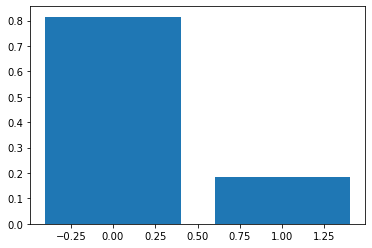

In [45]:
# Get feature importance

importance = model_tree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# Plot feature importance
plt.bar([ind for ind in range(len(importance))], importance)
plt.show()

And which feature is more useful to split the data?

Finally, once you are satisfied with the **training** and **testing**, use the model to predict on the larger area.

In [49]:
# Predict on the image stack
# In this case, the more powerful non-linear kernel model is used

Y_pred_all = model_tree.predict(stack)

C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


Printing large image takes time...


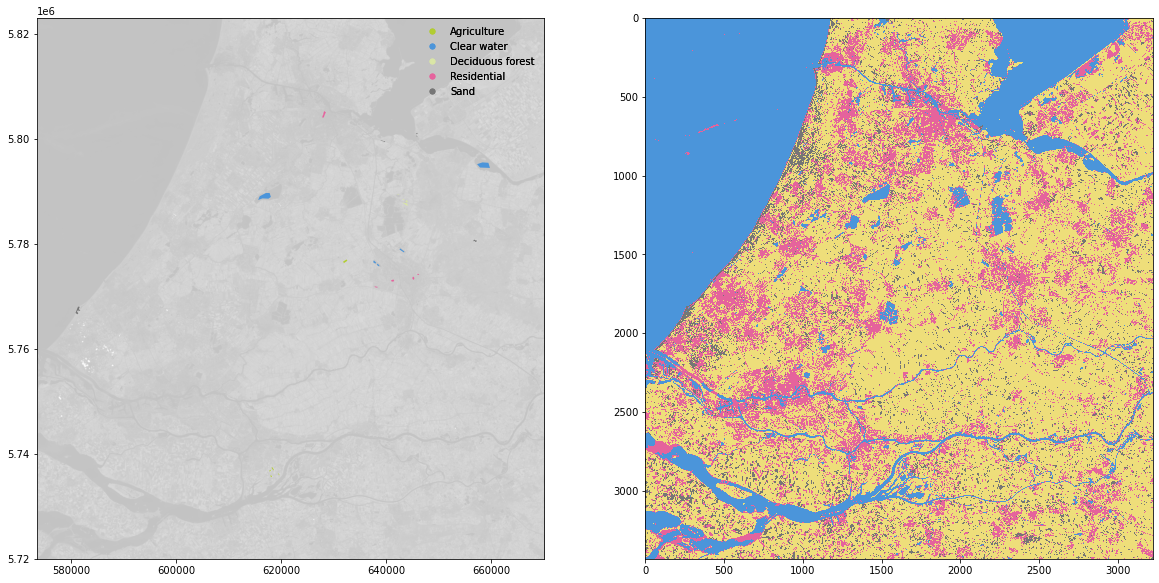

In [56]:
# Assign color codes to LULC types 
symbology = {'Agriculture': cols[5],
             'Clear water': cols[20],
             'Deciduous forest': cols[3],
             'Residential': cols[17],
             'Sand': cols[11]}

# Visualize
fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
show(b5_2020, ax=ax1, cmap='gray', alpha=0.25)
aoi.plot(ax=ax1, column='land_cover', legend=True, color=aoi['land_cover'].map(symbology))

from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=5, color=color) for color in symbology.values()]
leg_points = ax1.legend(custom_points, symbology.keys(), loc='upper right', frameon=False)
ax1.add_artist(leg_points)

# Assign color codes to LULC types 
symbology2 = {31: cols[17],
              52: cols[5],
              11: cols[20],
              21: cols[11],
              61: cols[3]}

# Visualize
# Because the predicted labels are still in one column, you need to reshape it back to original image shape
row, col = img.shape  # Get the original dimensions of the image
imin = min(symbology2)  # Colormap range
imax = max(symbology2)

print('Printing large image takes time...')
ax2.imshow(Y_pred_all.reshape(row, col), cmap=cm, interpolation='none', vmin=imin, vmax=imax)

In [53]:
Y_pred_all

array([11, 11, 11, ..., 52, 52, 52], dtype=uint16)

As always, please compile your own program in a compact way, where you can deal with different input data for **training**, and also staying flexible with **model configuration**. Please use the *.csv* file containing multiple bands and corresponding labels to test your model performance on different input bands.

In [47]:
# Start to load training data:

'''
import pandas as pd
lulc = pd.read_csv('uu_ml/data/stack_aoi_2015.csv')

# View some sample rows of the data
lulc.head()
'''

# You are also encourage to create your own AOI labels, load it, rasterize it and concantenate it together with the images:

'''
aoi = gpd.read_file('...')

rst = rasterio.open('...')  # Base image to rasterize the *.shp
meta = rst.meta.copy()  # Copy metadata from the base image
meta.update(compress='lzw')

...
'''

# Train your model and inspect the training processes

'''
from sklearn... import ...
    ...
    ...
tree_depth = ##    
band_list = [##, ##, ..., ##]
    
'''

# Evaluate the accuracy with different metrics

'''
...
...
'''

# Generalize your prediction from the trained model to larger areas

'''
...
...
'''

'\n...\n...\n'